## MTCNN & CNN & colab video (new)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import requests
from io import BytesIO
# extract and plot each detected face in a photograph
from matplotlib import pyplot
from matplotlib.patches import Rectangle,Circle
import zipfile
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder,Normalizer
from sklearn.svm import SVC
from random import choice
from PIL import Image as Img
from numpy import savez_compressed,asarray,load,expand_dims
from keras.models import load_model
# from keras_facenet import FaceNet
import tensorflow as tf
from tensorflow.keras import layers, models
import time
import json
from PIL import Image
from tqdm import tqdm
import codecs
import pandas as pd
from google.colab.patches import cv2_imshow

In [ ]:
# class Data_Using:

def unzip(zip_dir,out_dir):
    path_folder = out_dir

    zip_file_path = f'{zip_dir}'
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(path_folder)


def load_dataset(directory):
  	# enumerate folders, on per class
  images = []
  path_d = []
  allpath = []
  y = []
  for subdir in os.listdir(directory):

    # print(y)
       	# enumerate files
    for filename in os.listdir(directory+subdir+'/'):
      path = directory + subdir + '/' + filename
          #labels
      y.append(subdir)
      path_d.append(path)
      # print(path_d)
  # allpath.extend(path_d)

  print(path_d)
	  	# store
    # images.append(path_d)
  return path_d , y



def load_data_image(path_image):
    img = cv2.imread(path_image)
    # img = cv2.cvtColor(img,cv2.COLOR)
    return img


def load_data_video(path_video):

    frame_list = []
    # Load the video content using OpenCV
    cap = cv2.VideoCapture(path_video)
    # Loop through the frames and display them
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Display the frame
        # cv2_imshow( frame)

        frame_list.append(frame)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # Release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()
    frame_list = np.array(frame_list)
    return frame_list



def load_data_system_camera():
    # define a video capture object
    vid = cv2.VideoCapture(0)
    while(True):
        # Capture the video frame
        ret, frame = vid.read()
        # Display the resulting frame
        cv2.imshow('frame', frame)
        # cv2.imwrite('video.mp4',frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # After the loop release the cap object
    vid.release()
    # Destroy all the windows
    cv2.destroyAllWindows()


def load_data_json(json_file_path,save_path):#,output_path):
    # Load JSON file with image URLs
    # json_file_path = path_file
    # data = [json.loads(line) for line in open(json_file_path, 'r')]
    # # Download and preprocess images
    # image_folder = output_path
    # for i in range(len(data)): #enumerate(data):
    #     url = data[i]["content"]
    #     # response = wget.download(url)
    #     response = requests.get(url)
    #     # print(type(response))
    #     img = Image.open(response.content)
    #     img.save(f"{image_folder}/image_{i}.jpg")  # Save the image

    jsonData = []
    jsonData = [json.loads(line) for line in open(json_file_path, 'r')]
    # with codecs.open(json_file_path, 'rU', 'utf-8') as js:
    #  for line in js:
    #     jsonData.append(json.loads(line))
    # print(jsonData['content'])
    images = []
    for i in range(len(jsonData)):#,tqdm(jsonData):
          response = requests.get(jsonData[i]['content'],stream=True)
          print(BytesIO(response.raw))
          # img = np.asarray(Image.open(jsonData[i]['content']))
          img = np.asarray(Image.open(BytesIO(response.content)))
          images.append([img, jsonData[i]["annotation"]])
      # try:
      # # Send an HTTP request to the URL
      #   response = requests.get(json_file_path[i]['content'], stream=True)
      # # Check if the request was successful (status code 200)
      #   if response.status_code == 200:
      #     # Attempt to open the image using Pillow
      #     try:
      #         image = Image.open(BytesIO(response.content))
      #         # Save the image to the specified local path
      #         image.save(f"{save_path}/image_{i}.jpg")
      #         print(f"Image downloaded successfully to {save_path}")
      #     except Exception as e:
      #         print(f"Error opening image: {e}")
      #   else:
      #     print(f"Failed to download image. Status code: {response.status_code}")

      # except Exception as e:
      #   print(f"Error: {e}")




def load_data_keypoint(base_path):

  df = pd.read_csv(base_path + 'facial_keypoints.csv')
  df = df.fillna(0)
  # split columns two by two
  c = 0
  columns = {}
  temp = []
  for i, e in enumerate(list(df.columns)):
      temp.append(e)
      c += 1
      if c == 2:
          columns[e.split('_y')[0]] = temp
          temp = []
          c = 0
  keypoints_dict = {}
  for k in columns.keys():
    keypoints_dict[k] = df[columns[k]].values
  keypoints = np.array(list(keypoints_dict.values()))
  keypoints = np.swapaxes(keypoints, 0, 1)
  features = np.load(base_path + 'face_images.npz')['face_images']
  features = np.swapaxes(np.swapaxes(features, 1, 2), 0, 1)
  # reshape to be flat
  keypoints = keypoints.reshape(-1, 30)

  # reshape features to be in 4d
  features = features.reshape(7049, 96, 96, 1)


def load_lable_dataset(path_file):
    filenames=[]
    poses = []
    fil = open(path_file) # file txt
    while True:
      fn =fil.readline()
      if fn == '':
        break

      n = int(fil.readline())
      if n>0:
        filenames.append(fn[:-1])
        # print(n)
        pos=[]
        for i in range(n):
          mat = fil.readline().split()
          pos.append([int(mat[0]),int(mat[1]),int(mat[2]),int(mat[3])])
        poses.append(pos)
      else:
        fil.readline()

    return filenames , poses


In [ ]:
class Face_Detection_Recognition_Video:

    def __init__(self):
      # super.__init__(self)
      self.face_number = 0
      self.folder_number = 0



    def unet_face_detection(self,x_size, y_size):
        inputs = tf.keras.Input(shape=(x_size, y_size, 3))

        conv2 = layers.Conv2D(64, 3, padding='same')(inputs)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = layers.Conv2D(128, 3, padding='same')(pool2) #activation='relu'
        pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

        up1 = layers.UpSampling2D(size=(2, 2))(conv2)

        up2 = layers.UpSampling2D(size=(2, 2))(conv3)

        outputs = layers.Conv2D(1, 1, activation='sigmoid')(up2)#(conv5)

        model = models.Model(inputs=inputs, outputs=outputs)

        return model



    def train_unet_detection(self,trainx_trainy,testx_testy,E_number,x_size, y_size,x=None):
      self.model = self.unet_face_detection(x_size, y_size)
      self.model.summary()
      self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
      self.model.fit(trainx_trainy, epochs= E_number ,batch_size=32)#, steps_per_epoch = x)
      test_loss, test_acc = self.model.evaluate(testx_testy)
      return self.model,test_loss, test_acc


    def detection_model(self,image,model,x_size, y_size):
      random_face_1 = load_data_image(image)
      random_face_1 = np.array(random_face_1)
      # print(random_face.shape)
      random_face_1 = cv2.resize(random_face_1,(x_size,y_size))
      random_face = random_face_1.reshape(1,x_size, y_size,3)
      # print(random_face.shape)
      d_face = model.predict(random_face)
      d_face = d_face.reshape(x_size, y_size)
      print(d_face.shape)

      # Find Canny edges
      d_face = np.uint8(d_face*255)
      cv2_imshow(d_face)
      edged = cv2.Canny(d_face, 0.5, 1)
      # cv2.waitKey(0)

      # Finding Contours
      # Use a copy of the image e.g. edged.copy()
      # since findContours alters the image
      contours, hierarchy = cv2.findContours(edged,
          cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

      cv2_imshow(edged)
      # cv2.waitKey(0)

      print("Number of Contours found = " + str(len(contours)))

      # Draw all contours
      # -1 signifies drawing all contours
      cv2.drawContours(random_face_1, contours, -1, (0, 255, 0), 3)

      cv2_imshow(random_face_1)
      cv2.waitKey(0)
      cv2.destroyAllWindows()

      # return d_face


    # def get_face(self,picture,model):
    #     # pixels = path
    #     # pixels = asarray(pixels)
    #     picture = picture.resize((240,160))
    #     start_1=time.time()
    #     faces_pos = self.detection_model(picture,model)
    #     crop_face = []
    #     for i in range(len(faces_pos)):
    #       # get coordinates
    #       x1, y1, width, height = faces_pos[i]['box']
    #       x2, y2 = x1 + width, y1 + height
    #       # define subplot
    #       # pyplot.subplot(1, len(result_list), i+1)
    #       # pyplot.axis('off')
    #       # plot face
    #       Face = picture[y1:y2, x1:x2]
    #       # resize pixels to the model size
    #       Face = Img.fromarray(Face)
    #       Face = Face.convert('RGB')
    #       Face = Face.resize((160,160))
    #       Face = asarray(Face)#,dtype=np.float32)
    #       crop_face.append(Face)
    #     stop=time.time()
    #     print('detect_time:',stop-start_1)
    #     # print(stop)

    #     return crop_face





    def model_CNN(self):
      model_cnn = models.Sequential([
      layers.Conv2D(16, (3, 3), activation='relu', input_shape=(160, 160, 3)),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(32, (3, 3), activation='relu'),# input_shape=(160, 160, 3)),
      layers.MaxPooling2D((2, 2)),
      # layers.Dropout(0.2),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      # layers.Dropout(0.2),
      layers.Conv2D(128, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.Dropout(0.2),  # Dropout for regularization
      layers.Dense(128, activation='relu'),
      # layers.Dropout(0.2),
      # layers.Dense(64, activation='relu'),
      layers.Dense(9, activation='softmax')  # num_classes is the number of identities
      ])

      return model_cnn

    def train_cnn_model(self,trainx,trainy,testx, testy,E_number):
      self.model = self.model_CNN()
      self.model.summary()
      self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      self.model.fit(trainx, trainy, epochs= E_number)
      test_loss, test_acc = self.model.evaluate(testx, testy)
      return self.model , test_loss, test_acc


    def recognition_model(self,image,model):
      random_face = np.array(image)
      random_face = random_face.reshape(1,160,160,3)
      w_predict = capture_output(self.model.predict)
      pred = w_predict(random_face)
      # random_face_name = out_encoder.inverse_transform([random_face_class])
      out_encoder = LabelEncoder()
      out_encoder.fit(trainy)
      class_index = tf.argmax(pred, axis=1)
      # confidence = tf.reduce_max(pred[0][random_face_class])
      pred_name = out_encoder.inverse_transform(class_index)
      # print('Predicted: %s' % pred_name)
      # print('Expected: %s' % random_face_name[0])
      # print(f"Predicted class: {class_index}, Confidence: {confidence * 100:.2f}%")
      # pyplot.figure()
      # pyplot.imshow(random_face.reshape(160,160,3))
      # pyplot.show()
      return pred_name

    def save_faces(self,data_face):
      folder_name = 'Faces'+f'{self.folder_number}'
      if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
      cv2.imwrite(folder_name + '/' + f'{self.face_number}.jpg',data_face)
      self.face_number += 1

    def face_counting(self,):
      pass

In [ ]:
#Unzip folders WIDER

path_train = '/content/drive/MyDrive/WIDER dataset/WIDER_train.zip'
path_val = '/content/drive/MyDrive/WIDER dataset/WIDER_val.zip'
# path_test = '/content/drive/MyDrive/WIDER dataset/WIDER_test.zip'
path_box = '/content/drive/MyDrive/WIDER dataset/wider_face_split.zip'
output_1 = '/content/photos_WIDER'

train_dataset = unzip(path_train,output_1)
val_dataset = unzip(path_val,output_1)
# test_dataset = unzip(path_test,output_1)
boxes = unzip(path_box,output_1)

In [ ]:
# Load dataset WIDER
train_txt = '/content/photos_WIDER/wider_face_split/wider_face_train_bbx_gt.txt'
val_txt = '/content/photos_WIDER/wider_face_split/wider_face_val_bbx_gt.txt'

train_address , train_boxes = load_lable_dataset(train_txt)
val_address , val_boxes = load_lable_dataset(val_txt)

In [ ]:
# Preprocess image
import random
class wider_dataset:
  def __init__(self,main_path,box_data,path_images,batch_size,x_size, y_size):
        self.main_path = main_path
        self.box_data = box_data
        self.path_images = path_images
        self.batch_size = batch_size
        self.x_size = x_size
        self.y_size = y_size

  def __len__(self):
        return len(self.path_images)

  def __getitem__(self,idx):
        fname = os.path.join(self.main_path,self.path_images[idx])

        img = load_data_image(fname)
        # print(img.shape)
        x = cv2.resize(img, (self.x_size, self.y_size))/255.0
        x = x.reshape(1,self.x_size,self.y_size,3)
        # x = self.imgarr[idx]
        # x = self.augment(x)
        masks = gen_mask(img,self.box_data[idx]).astype('float32')
        # print(masks.shape)
        y =  cv2.resize(masks, (self.x_size, self.y_size))
        # y = self.labels[idx].astype(np.int64)
        return x, y

  def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            if i == self.__len__()-1:
                reidx = random.sample(population = list(range(self.__len__())),k = self.__len__())
                self.box_data = self.box_data[reidx]
                self.path_images = self.path_images[reidx]



def data_create(main_path,box_data,path_images,batch_size,x_size, y_size):
  l=len(path_images)
  start = 0
  while start<l:
    data = []
    labels = []
    m = np.min([batch_size,l-start])
    # path_files = '/content/photos_WIDER/WIDER_train/images/'
    for i in range(m):
      # path = path_images[i]
      # ind = np.random.randint(0,len(path_images[i])-1)
      fname = os.path.join(main_path,path_images[start+i])

      img = load_data_image(fname)
      img_1 = cv2.resize(img, (x_size, y_size))
      data.append(img_1)

      masks = gen_mask(img,box_data[start+i])
      masks =  cv2.resize(masks, (x_size, y_size))
      masks = masks[:,:, np.newaxis]
      # print('maskshape:',masks.shape)
      labels.append(masks)
    yield np.asarray(data),np.asarray(labels)
    start += batch_size
  return None


def gen_mask(img,pose):
  mask = np.zeros(img.shape[:-1],dtype='int')
  # mask = mask[:,:, np.newaxis]
  for x,y,w,h in pose:
    mask[y:y+h,x:x+w]=1
    # print('mask shape:',mask.shape)
  return mask

main_p_train = '/content/photos_WIDER/WIDER_train/images/'
main_p_val = '/content/photos_WIDER/WIDER_val/images/'
# train_image_labels = data_create(main_p_train,train_boxes,train_address,32,256,256)
# # train_image_labels = tf.data.Dataset.from_generator(train_image_labels)
# val_image_labels = data_create(main_p_val,val_boxes,val_address,64,256,256)
train_image_labels = wider_dataset(main_p_train,np.asarray(train_boxes),np.asarray(train_address),32,256,256)
val_image_labels = wider_dataset(main_p_val,np.asarray(val_boxes),np.asarray(val_address),20,256,256)
from tensorflow.data import Dataset
ds_train = Dataset.from_generator(train_image_labels, output_types = (tf.float32, tf.int64), output_shapes = (tf.TensorShape([None,256,256,3]),tf.TensorShape([256,256])))
ds_val = Dataset.from_generator(val_image_labels, output_types = (tf.float32, tf.int64), output_shapes = (tf.TensorShape([None,256,256,3]),tf.TensorShape([256,256])))

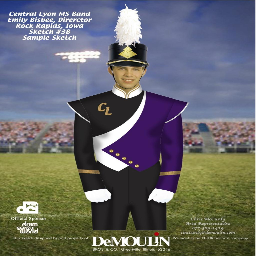

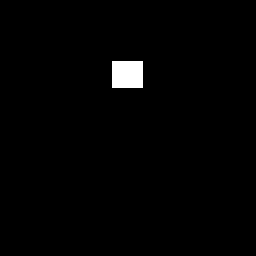

In [ ]:
from google.colab.patches import cv2_imshow
for x,y in ds_train.batch(1):
    cv2_imshow(x.cpu().numpy().reshape(256,256,3)*255)
    cv2_imshow(y.cpu().numpy().reshape(256,256)*255)
    break

In [ ]:
# Train model unet
face_detect = Face_Detection_Recognition_Video()
# train_unet_model = face_detect.train_unet_detection(train_image_labels,val_image_labels,20,256,256)
train_unet_model = face_detect.train_unet_detection(ds_train,ds_val,10,256,256)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 up_sampling2d_9 (UpSamplin  (None, 256, 256, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 1)       129 

In [ ]:
train_unet_model[0].save_weights('/content/drive/MyDrive/Facenet/Model_detect/weightmodel_d')
train_unet_model[0].save('/content/drive/MyDrive/Facenet/Model_detect/Mymodel_d.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_detect_1 = tf.keras.models.load_model('/content/drive/MyDrive/Facenet/Model_detect/Mymodel_d.h5')

1/1 [==============================] - 0s 19ms/step
(256, 256)


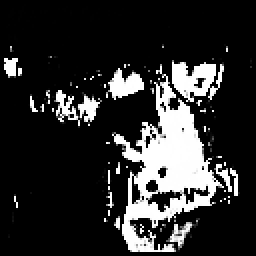

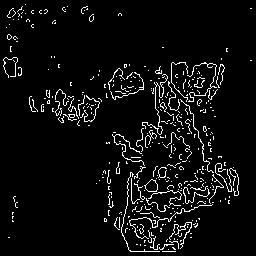

Number of Contours found = 378


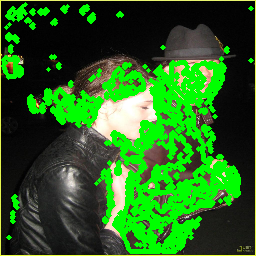

In [ ]:
face_detect = Face_Detection_Recognition_Video()
# imgs = '/content/1411047720.webp'
imgs = "/content/photos_WIDER/WIDER_val/images/19--Couple/19_Couple_Couple_19_1014.jpg"
matrix = face_detect.detection_model(imgs,model_detect_1,256,256)

# # Example matrix
# # matrix = np.random.rand(10, 10)
# import matplotlib.pyplot as plt
# # Plot the matrix using Matplotlib
# # plt.imshow(matrix, cmap='coolwarm', interpolation='nearest')
# # plt.colorbar(label='Value')
# # plt.title('Matrix Plot')
# # plt.xlabel('X-axis')
# # plt.ylabel('Y-axis')
# # plt.show()

In [ ]:
# Load dataset face detection

def image_dataset(directory):
  X = list()
  newlabels = list()
  files = load_dataset(directory)
  labels =
  print(len(files),len(labels))
  for fil,label in zip(files,labels):
    facedetect = Face_Detection_Recognition_Video()
    img = load_data_image(fil)
    if not type(img) == type(None):
     faces , pos = facedetect.get_face(img)
    if not len(faces)== 0:
      X.append(faces)
      newlabels.append(label)

  return asarray(X), asarray(newlabels)



# paths train and validation
train_path = '/content/photos/train/'
val_path = '/content/photos/val/'
# load train dataset
trainX, trainy = faces_dataset(train_path)
# load test dataset
testX, testy = faces_dataset(val_path)
# save arrays to one file in compressed format
# savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

In [ ]:
# #Unzip folders Mydataset
path = '/content/drive/MyDrive/Facenet/Facedata.zip'
output_2 = '/content/photos'
data = unzip(path,output_2)

In [ ]:
!rm -R /content/photos/__MACOSX

In [ ]:
!find . -name "*.DS_Store" -type f -delete

In [ ]:
# Load dataset face recognition

def faces_dataset(directory):
  X = list()
  newlabels = list()
  files , labels = load_dataset(directory)
  print(len(files),len(labels))
  for fil,label in zip(files,labels):
    facedetect = Face_Detection_Recognition_Video()
    img = load_data_image(fil)
    if not type(img) == type(None):
     faces , pos = facedetect.get_face(img)
    if not len(faces)== 0:
      X.append(faces)
      newlabels.append(label)

  return asarray(X), asarray(newlabels)



# paths train and validation
train_path = '/content/photos/train/'
val_path = '/content/photos/val/'
# load train dataset
trainX, trainy = faces_dataset(train_path)
# load test dataset
testX, testy = faces_dataset(val_path)
# save arrays to one file in compressed format
# savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

In [ ]:
# Prepare data for Cnn

Cnn_trainx = []
for p in trainX:
  Cnn_trainx.append(p[0])
Cnn_trainx = np.array(Cnn_trainx)
print(Cnn_trainx.shape)

Cnn_testx = []
for p in testX:
  Cnn_testx.append(p[0])
Cnn_testx = np.array(Cnn_testx)
print(Cnn_testx.shape)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
train_y = out_encoder.transform(trainy)
print(train_y.shape)
test_y = out_encoder.transform(testy)
print(test_y.shape)

(230, 160, 160, 3)
(44, 160, 160, 3)
(230,)
(44,)


In [ ]:
# Train model
face_detect = Face_Detection_Recognition_Video()
train_model = face_detect.train_cnn_model(Cnn_trainx,train_y,Cnn_testx,test_y,100)

In [ ]:
train_model[0].save_weights('/content/drive/MyDrive/Facenet/Model/weightmodel_1')
train_model[0].save('/content/drive/MyDrive/Facenet/Model/Mymodel_1.h5')

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
from PIL import Image as Img
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = Img.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # get face region coordinates
    faces , pos = face_detect.get_face(img)
    # get face bounding box for overlay
    # for (x,y,w,h)in pos:
    #   bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
    for i in range(len(faces)):
      recog_model = face_detect.recognition_model(faces[i],train_model)
      txt = recog_model[0]
      # print(txt , type(txt))
      font = cv2.FONT_HERSHEY_SIMPLEX
      # fontScale
      fontScale = 1
      # Blue color in BGR
      color = (255, 0, 0)
      # Line thickness of 2 px
      thickness = 2

      x, y, w, h = pos[i]['box']
      # cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      bbox_array = cv2.putText(bbox_array,txt,(x,y-10),font,fontScale,color,thickness)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

detect_time: 1.288156270980835
all_time: 1.2881629467010498
detect_time: 1.7811272144317627
all_time: 1.783987045288086
detect_time: 0.940363883972168
all_time: 0.9420263767242432
detect_time: 0.9572761058807373
all_time: 0.9590651988983154
detect_time: 0.9216337203979492
all_time: 0.9234073162078857
detect_time: 0.9193572998046875
all_time: 0.9209990501403809
detect_time: 1.4058005809783936
all_time: 1.4087865352630615
detect_time: 0.9195396900177002
all_time: 0.9210314750671387
detect_time: 0.9212265014648438
all_time: 0.9227612018585205
detect_time: 0.9142789840698242
all_time: 0.915369987487793
detect_time: 1.3764195442199707
all_time: 1.3782432079315186
